In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from varname import nameof

In [3]:
def gamma(N, ro, ri, h,
         mu = 1.25663753*10**(-9) # H/mm
         ):
    # ro, ri are outer and inner radius (mm)
    # h is height (mm)
    LN = N**2*h*mu/(2*np.pi)*np.log(ro/ri)
    L1 = (ri+ro)/2*mu*(np.log(8*(ro+ri)/(ro-ri))-2)
    return L1/LN

def Ri(L,N,ro,h,
      mu = 1.25663753*10**(-9) # H/mm
      ): 
    # calculate inner radius of inductor with specific inductance
    return ro*np.exp(-L*2*np.pi/(N**2*h*mu))

def Resistance(N, ro, ri, h,
              alpha = 0.2, # mm: min width of trace
              #delta = 9.22 * 10**(-3), # mm at 50 MHz
              delta = 17.744 * 10**(-3), # mm at 13.5 MHz
              rho = 1.678 * 10**(-5) # Ohm*mm
              ):
    ro_via = (2*np.pi*ro-alpha*N)/N/2
    ri_via = (2*np.pi*ri-alpha*N)/N/2
    if ri_via > 0.45:
        R_slab = 2*rho*N/(2*np.pi*delta)*np.log((2*np.pi*ro-alpha*N)/(2*np.pi*ri-alpha*N))
        R_vias = h*rho/(np.pi*delta)*(1/ro_via+1/ri_via)

        R = N*(R_slab+R_vias)
    else:
        R = 0
    return R

def SelfCapacitance(N, ro, ri, h,
                    ht = 35e-3, # thickness of trace: 1oz copper is 35 um 
                    alpha = 0.2, # mm: min width of trace
                    epsilon_r = 3.48
                   ):
    epsilon_0 = 8.854e-15 # F/mm
    
    l = ro-ri # length of a single trace
    A = ht*l
    d = alpha

    ro_via = (2*np.pi*ro-alpha*N)/N/2
    ri_via = (2*np.pi*ri-alpha*N)/N/2
    
    do_s = 2*ri_via
    do_l = 2*ro_via
    p_s = do_s+alpha
    p_l = do_l+alpha

    if ri_via > 0.45:
        Ctttrace = epsilon_r*epsilon_0*A/d
        Cttvia_s = 2*epsilon_0*h/np.sqrt((p_s/do_s)**2-1)*np.arctan(np.sqrt(1+2/(p_s/do_s-1)))
        Cttvia_l = 2*epsilon_0*h/np.sqrt((p_l/do_l)**2-1)*np.arctan(np.sqrt(1+2/(p_l/do_l-1)))
        #print(Ctttrace,Cttvia_s,Cttvia_l)
        C = (2*Ctttrace+Cttvia_l+Cttvia_s)/N
    else:
        C = 0
    return C

In [4]:
Nros = 201 # rows
Nturns = 191 # cols
ros = np.linspace(7, 100, Nros)
Ns = np.linspace(10, 200, Nturns)

ris = np.array([[0.0]*Nturns]*Nros)
Ms = np.array([[0.0]*Nturns]*Nros)
gammas = np.array([[0.0]*Nturns]*Nros)
Rs = np.array([[0.0]*Nturns]*Nros)
Cs = np.array([[0.0]*Nturns]*Nros)
available = np.array([[0.0]*Nturns]*Nros)

L = 6 * 10**(-6) # H
h = 0.250*25.4
alpha = 0.3
i,j = 0,0
for ro in ros:
    for N in Ns:
        ri = Ri(L,N,ro,h)
        ri_via = (2*np.pi*ri-alpha*N)/N/2
        ro_via = (2*np.pi*ro-alpha*N)/N/2
        #if ri_via > 0.45 and (ro_via+ro) < 12.7: # min radius of via and outer size limit
        if ri_via > 0.45 and (ro_via+ro) < 200: # min radius of via
            available[i][j] = 1
            ris[i][j] = ri
            Ms[i][j] = ro/ri
            gammas[i][j] = gamma(N, ro, ri, h)
            Rs[i][j] = Resistance(N, ro, ri, h)
            Cs[i][j] = SelfCapacitance(N, ro, ri, h)
        else:
            available[i][j] = 0
            ris[i][j] = ri
            Ms[i][j] = 0
            gammas[i][j] = 0
            Rs[i][j] = 2
            Cs[i][j] = 0
        j += 1
    i += 1
    j = 0
score_gamma = gammas/np.max(gammas)
score_R = Rs/np.max(Rs)
p = 0.8
score = 1-(p*score_R + (1-p)*score_gamma)

In [5]:
def plotResult(Result,
                Nrows = ros,
                Ncols = Ns
              ):
    X,Y = np.meshgrid(Ncols,Nrows)
    # Plot the density map using nearest-neighbor interpolation
    
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(X,Y,Result)
    fig.colorbar(im, ax=ax)
    #ax.set_title(nameof(Result))
    plt.xlabel('N')
    plt.ylabel('Outer radius (mm)')
    plt.show()

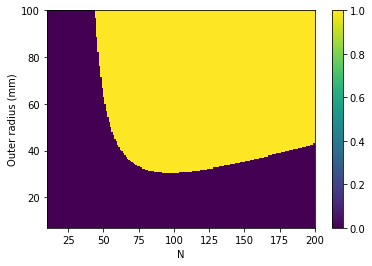

In [6]:
plotResult(available)

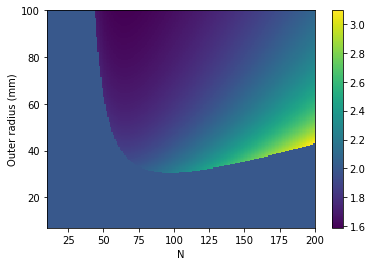

In [7]:
plotResult(Rs)

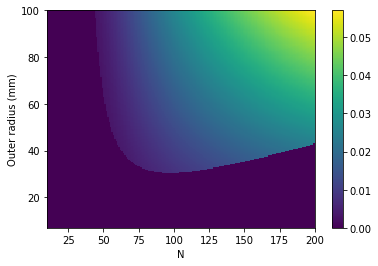

In [8]:
%matplotlib inline
plotResult(gammas)

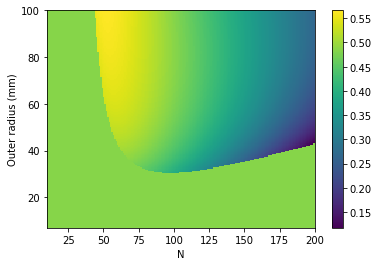

In [9]:
plotResult(score)

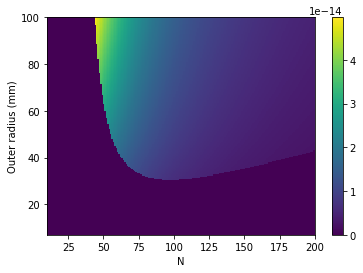

In [10]:
plotResult(Cs)

In [12]:
rr = 114
ros[rr]

60.010000000000005

60.010000000000005

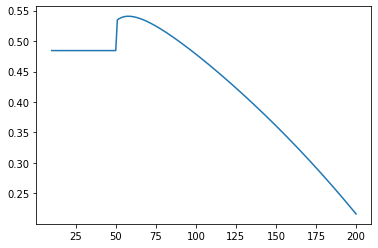

In [13]:
plt.plot(Ns,score[rr])
ros[rr]

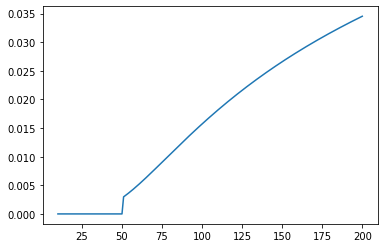

In [14]:
plt.plot(Ns,gammas[rr])

1.8105203382722288


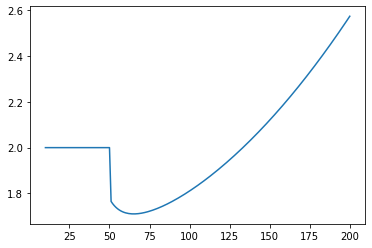

In [15]:
plt.plot(Ns,Rs[rr])
print(min(Rs[rr][90:-1]))

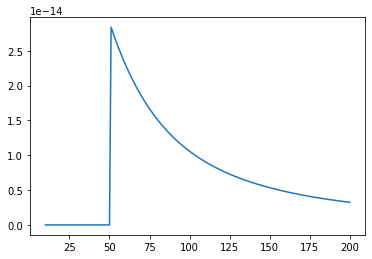

In [16]:
plt.plot(Ns,Cs[rr])

## Calculate a specific sample

In [17]:
N = 65
L = 6* 10**(-6) # H
h = 0.25*25.4
ro = 60
alpha = 0.3
ri = Ri(L,N,ro,h)
gamma_1 = gamma(N, ro, ri, h)
R_1 = Resistance(N, ro, ri, h)
C_1 = SelfCapacitance(N, ro, ri, h)
score_gamma_1 = gamma_1/np.max(gammas)
score_R_1 = R_1/np.max(Rs)
p = 0.8
score_1 = 1-(p*score_R_1 + (1-p)*score_gamma_1)
ro_via = (2*np.pi*ro-alpha*N)/N/2
ri_via = (2*np.pi*ri-alpha*N)/N/2
print('ri = ', ri)
print('Resistance', R_1)
print('gamma = ',gamma_1)
print('Self capacitance =',C_1*1e12,'pF')
print('score_1 = ', score_1)
print('diameter of outer via is ',ro_via*2)
print('diameter of inner via is ',ri_via*2)
print('diameter of outer dim is ',ro*2+ro_via*2)

ri =  19.61199873581633
Resistance 1.7101925651949843
gamma =  0.0063200234624390976
Self capacitance = 0.020568613355098048 pF
score_1 =  0.537184791614064
diameter of outer via is  5.499863360473464
diameter of inner via is  1.5957818815585503
diameter of outer dim is  125.49986336047347


## Append desired dimensions

In [366]:
save = True

In [481]:
if save == True:
    des_L.append(L)
    des_ro.append(ro)
    des_ri.append(ri)
    des_R.append(R_1)
    des_sC.append(C_1)
    des_ro_via.append(ro_via*2)
    des_ri_via.append(ri_via*2)
    des_N.append(N)
print('L = ',des_L)

L =  [8.439999999999999e-07, 7.54e-07, 6.81e-07, 6.2e-07, 5.699999999999999e-07, 5.27e-07, 4.9e-07, 4.58e-07, 4.2999999999999996e-07, 4.05e-07]


In [483]:
print('N = ',des_N)

N =  [30, 26, 24, 22, 20, 19, 18, 17, 16, 15]


In [484]:
des_ro

[11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05]

In [485]:
des_ri

[5.280511691318732,
 4.591354840661164,
 4.355731024447756,
 4.0300383586568875,
 3.5980196693128943,
 3.500673671080066,
 3.3588797232709484,
 3.172679485532023,
 2.944215324895772,
 2.6781014299071377]

In [486]:
des_R

[0.7898925786175889,
 0.6790308651814487,
 0.6044300997700938,
 0.5429365211978912,
 0.49451546915904854,
 0.4547226096162188,
 0.42101456465734055,
 0.3926138803362764,
 0.3688611018910822,
 0.34921796986416465]

In [487]:
des_sC

[2.0311415755276132e-14,
 2.5013907301858622e-14,
 2.8200839035245172e-14,
 3.199309815324091e-14,
 3.653385140469791e-14,
 3.9454554461435237e-14,
 4.268832462451426e-14,
 4.628409604048123e-14,
 5.030366880913142e-14,
 5.482738584627046e-14]

In [488]:
des_ro_via

[2.114306588144481,
 2.4703537555513244,
 2.692883235180602,
 2.95587262019702,
 3.271459882216722,
 3.454168297070234,
 3.657177646907469,
 3.8840704496667313,
 4.139324852770902,
 4.4286131762889624]

In [489]:
des_ri_via

[0.9059477824427961,
 0.9095512798034652,
 0.9403277156181845,
 0.9509762637492313,
 0.9303512160584966,
 0.9576516513347734,
 0.972470206991081,
 0.9726195957579352,
 0.9561906544098804,
 0.9218005037019446]

# The self-capacitance of PCB-based inductor
The major theory of self-capacitance is to calculate $C_{turn-to-turn}$, which is easy to calculate for the PCB based inductor:

#### The trace capacitances:
$$
C_{tt-trace} = \epsilon_r\epsilon_0 A/d
$$
where $\epsilon_r = 3.48$ for Rogers 4350b, $\epsilon_0 = 8.854\times 10^{-12}$. 

Area of the side of trace $A = h\times l$, where $h = 35 \mu m$ for 1oz copper ($h = 70 \mu m$ for 2oz copper), l is the length of one trace: $l = r_{out} - r_{in} \approx 5mm$

Distance between two adjacent trace is the separation in the simulation ($\alpha$): $d = \alpha = 0.2mm$

In [233]:
epsilon_r = 3.48
epsilon_0 = 8.854e-15 # F/mm
h = 35e-3 # mm
l = 20
A = h*l
d = 0.2
N = 20
Ctttrace = epsilon_r*epsilon_0*A/d
turn = 'Turn-to-turn trace capacitance is '+ str(Ctttrace/1e-12)+' pF'
print(turn)
total = 'Total capacitance is '+ str(Ctttrace/(N*1e-12))+' pF'
print(total)

Turn-to-turn trace capacitance is 0.10784172000000002 pF
Total capacitance is 0.005392086000000001 pF


#### The via capacitances:
$$
C_{tt-via} = \frac{2\epsilon_0 l_T}{\sqrt{[\frac{1}{\epsilon_r}\ln(\frac{d_o}{d_i})+\frac{p}{d_o}]^2-1}}\times
\tan^{-1}\left[\sqrt{1+\frac{2}{\frac{1}{\epsilon_r}\ln(\frac{d_o}{d_i})+\frac{p}{d_o}-1}}\right]
$$
where $l_T$ is the length of via, i.e. the thickness of the PCB board.

$\epsilon_r$ is the relative permittivity of Rogers 4350b.

$d_o, d_i$ are the outer (with insulating tube) and inner (bare copper) diameter of wire. Because the via has no insulating tube, $d_o = d_i$ is the diameter of via.

$p$ is the winding pitch, which is the center-to-center distance between two adjacent vias. Here $p = d_o + \alpha$ 

In [234]:
lt = 3.125
do_s = 1.08
do_l = 7.33
alpha = 0.2
p_s = do_s+alpha
p_l = do_l+alpha

Cttvia_s = 2*epsilon_0*lt/np.sqrt((p_s/do_s)**2-1)*np.arctan(np.sqrt(1+2/(p_s/do_s-1)))
turn1 = 'Turn-to-turn small via capacitance is '+ str(Cttvia_s/1e-12)+' pF'
print(turn1)
Cttvia_l = 2*epsilon_0*lt/np.sqrt((p_l/do_l)**2-1)*np.arctan(np.sqrt(1+2/(p_l/do_l-1)))
turn2 = 'Turn-to-turn large via capacitance is '+ str(Cttvia_l/1e-12)+' pF'
print(turn2)

Turn-to-turn small via capacitance is 0.11200162034976892 pF
Turn-to-turn large via capacitance is 0.342414077989886 pF


# Calculate the desired inductance

In [61]:
f = 50e6
Cs = np.linspace(12e-12, 25e-12, 10)
Ls = []
for C in Cs:
    Ls.append(1/(2*np.pi*f)**2/C)
print([L*1e6 for L in Ls])

fs = []
for L in Ls:
    fs.append(1/(2*np.pi*np.sqrt(L*17.8e-12)))
print('The corresponding frequencies are (MHz)')
print([f/1e6 for f in fs]) 

print('\n If subtract 100 nH')
print([L*1e6-0.1 for L in Ls])
print('\n')
fns = []
for L in Ls:
    fns.append(1/(2*np.pi*np.sqrt((L+1e-7)*17.8e-12)))
print('If we use the previous number, the frequencies will become: ')
print([f/1e6 for f in fns]) 
print('The corresponding capacitances are:')

Cns = []
for L in Ls:
    Cns.append(1/(2*np.pi*f)**2/(L+1e-7))
print([C*1e12 for C in Cns])

[0.8443431970194816, 0.7536286386620166, 0.6805154125231642, 0.6203337774020681, 0.56993165798815, 0.5271044235728556, 0.49026379181776353, 0.458236508935196, 0.4301371003684151, 0.40528473456935116]
The corresponding frequencies are (MHz)
[41.053541362798, 43.45416745449791, 45.72894138180027, 47.895798256597665, 49.96877926639076, 51.95912154867385, 53.87598465779017, 55.726951590617446, 57.518384402898526, 59.255682892497155]

 If subtract 100 nF
[0.7443431970194816, 0.6536286386620166, 0.5805154125231642, 0.5203337774020681, 0.46993165798815006, 0.4271044235728556, 0.3902637918177635, 0.358236508935196, 0.33013710036841515, 0.3052847345693511]


If we use the previous number, the frequencies will become: 
[38.81907677642994, 40.82964858371321, 42.69916564189463, 44.44708058863924, 46.08874473716811, 47.636538753797595, 49.10062935493618, 50.48949331943493, 51.81029096944522, 53.069138997637964]
The corresponding capacitances are:
[10.72927553903346, 11.869468648702943, 12.981317475

In [56]:
L = 0.51e-6
f = 52.82e6
1/(2*np.pi*f)**2/L

1.7802184325259065e-11

# Calculate the resistance of wire-based coil

In [204]:
rho = 1.678 * 10**(-5) # Ohm*mm
delta = 9.22 * 10**(-3) # mm
l = 680 # mm
r = 0.6
S = 2.0*np.pi*r*delta
R = rho*l/S
R

0.32827577054514867

In [3]:
1/np.sqrt(0.886*12.87e-6)/2/np.pi

47.13179686652352

In [4]:
1/(2*np.pi*50e6)**2/12.87e-12

7.872663841673488e-07